## Chapter 06. 프로모션 효율 예측 (Random Forest)

### 01. 분석의 목적
- Random Forest를 이용하여, 프로모션에 반응할 고객을 예측
- 고객 데이터와 거래 데이터를 통합 활용
- Random Forest는 Decision Tree에서 발전된 모델이며, 기본적인 알고리즘의 특성은 Decision Tree를 기반으로 함

### 02. 모듈, 데이터 로딩 및 데이터 확인

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mem = pd.read_csv("./data/member.csv")
tran = pd.read_csv("./data/transaction.csv")

In [3]:
mem.head()

,id,recency,zip_code,is_referral,channel,conversion
0,906145,10,Surburban,0,Phone,0
1,184478,6,Rural,1,Web,0
2,394235,7,Surburban,1,Web,0
3,130152,9,Rural,1,Web,0
4,940352,2,Urban,0,Web,0


In [4]:
mem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           64000 non-null  int64 
 1   recency      64000 non-null  int64 
 2   zip_code     64000 non-null  object
 3   is_referral  64000 non-null  int64 
 4   channel      64000 non-null  object
 5   conversion   64000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.9+ MB


In [5]:
mem.drop("id", axis=1).describe()

,recency,is_referral,conversion
count,64000.000000,64000.000000,64000.000000
mean,5.763734,0.502250,0.146781
std,3.507592,0.499999,0.353890
min,1.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000
50%,6.000000,1.000000,0.000000
75%,9.000000,1.000000,0.000000
max,12.000000,1.000000,1.000000


In [6]:
tran.head()

,id,num_item,total_amount
0,906145,5,34000
1,906145,1,27000
2,906145,4,33000
3,184478,4,29000
4,394235,4,33000


In [7]:
tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196836 entries, 0 to 196835
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   id            196836 non-null  int64
 1   num_item      196836 non-null  int64
 2   total_amount  196836 non-null  int64
dtypes: int64(3)
memory usage: 4.5 MB


In [8]:
tran.drop("id", axis=1).describe()

,num_item,total_amount
count,196836.000000,196836.000000
mean,3.078365,21837.102969
std,1.478408,8218.005565
min,1.000000,8000.000000
25%,2.000000,15000.000000
50%,3.000000,22000.000000
75%,4.000000,29000.000000
max,6.000000,38000.000000


### 03. Python Tip: Groupby, Index, Data Merge

In [9]:
import pandas as pd

data = pd.read_csv("./data/transaction.csv")

data.head(100)

,id,num_item,total_amount
0,906145,5,34000
1,906145,1,27000
2,906145,4,33000
3,184478,4,29000
4,394235,4,33000
...,...,...,...
95,969084,5,13000
96,969084,3,31000
97,969084,1,13000
98,969084,2,22000


In [10]:
data.groupby("id").sum()

,num_item,total_amount
id,,
100001,7,52000
100008,5,26000
100032,8,62000
100036,15,129000
100070,13,85000
...,...,...
999932,5,32000
999981,8,91000
999990,9,84000


In [11]:
data.groupby("id").mean()

,num_item,total_amount
id,,
100001,3.500000,26000.000000
100008,5.000000,26000.000000
100032,2.666667,20666.666667
100036,3.000000,25800.000000
100070,3.250000,21250.000000
...,...,...
999932,5.000000,32000.000000
999981,2.000000,22750.000000
999990,3.000000,28000.000000


In [12]:
data.groupby("id").count()

,num_item,total_amount
id,,
100001,2,2
100008,1,1
100032,3,3
100036,5,5
100070,4,4
...,...,...
999932,1,1
999981,4,4
999990,3,3


In [13]:
data.groupby("id").describe()

num_item                                                total_amount  \
          count      mean       std  min   25%  50%   75%  max        count   
id                                                                            
100001      2.0  3.500000  0.707107  3.0  3.25  3.5  3.75  4.0          2.0   
100008      1.0  5.000000       NaN  5.0  5.00  5.0  5.00  5.0          1.0   
100032      3.0  2.666667  2.081666  1.0  1.50  2.0  3.50  5.0          3.0   
100036      5.0  3.000000  1.581139  1.0  2.00  3.0  4.00  5.0          5.0   
100070      4.0  3.250000  1.500000  2.0  2.00  3.0  4.25  5.0          4.0   
...         ...       ...       ...  ...   ...  ...   ...  ...          ...   
999932      1.0  5.000000       NaN  5.0  5.00  5.0  5.00  5.0          1.0   
999981      4.0  2.000000  0.816497  1.0  1.75  2.0  2.25  3.0          4.0   
999990      3.0  3.000000  1.000000  2.0  2.50  3.0  3.50  4.0          3.0   
999995      1.0  2.000000       NaN  2.0  2.00  2.0  2.00  2.0          1.0   
999997      1.0  2.000000       NaN  2.0  2.00  2.0  2.00  2.0          1.0   

                                                                        \
                mean           std      min      25%      50%      75%   
id                                                                       
100001  26000.000000   2828.427125  24000.0  25000.0  26000.0  27000.0   
100008  26000.000000           NaN  26000.0  26000.0  26000.0  26000.0   
100032  20666.666667   8736.894948  11000.0  17000.0  23000.0  25500.0   
100036  25800.000000  11344.602241   8000.0  21000.0  32000.0  33000.0   
100070  21250.000000   7932.002690  13000.0  16000.0  20500.0  25750.0   
...              ...           ...      ...      ...      ...      ...   
999932  32000.000000           NaN  32000.0  32000.0  32000.0  32000.0   
999981  22750.000000  10078.855755   9000.0  19500.0  24500.0  27750.0   
999990  28000.000000   5291.502622  22000.0  26000.0  30000.0  31000.0   
999995  27000.000000           NaN  27000.0  27000.0  27000.0  27000.0   
999997  13000.000000           NaN  13000.0  13000.0  13000.0  13000.0   

                 
            max  
id               
100001  28000.0  
100008  26000.0  
100032  28000.0  
100036  35000.0  
100070  31000.0  
...         ...  
999932  32000.0  
999981  33000.0  
999990  32000.0  
999995  27000.0  
999997  13000.0  

[64000 rows x 16 columns]

In [14]:
data.set_index("id", inplace=True)

data

,num_item,total_amount
id,,
906145,5,34000
906145,1,27000
906145,4,33000
184478,4,29000
394235,4,33000
...,...,...
536246,5,24000
927617,5,26000
927617,3,22000


In [15]:
data.reset_index()

,id,num_item,total_amount
0,906145,5,34000
1,906145,1,27000
2,906145,4,33000
3,184478,4,29000
4,394235,4,33000
...,...,...,...
196831,536246,5,24000
196832,927617,5,26000
196833,927617,3,22000
196834,927617,3,18000


In [16]:
data.reset_index(drop=True)

,num_item,total_amount
0,5,34000
1,1,27000
2,4,33000
3,4,29000
4,4,33000
...,...,...
196831,5,24000
196832,5,26000
196833,3,22000
196834,3,18000


In [17]:
data.groupby("id").sum().reset_index()

,id,num_item,total_amount
0,100001,7,52000
1,100008,5,26000
2,100032,8,62000
3,100036,15,129000
4,100070,13,85000
...,...,...,...
63995,999932,5,32000
63996,999981,8,91000
63997,999990,9,84000
63998,999995,2,27000


In [18]:
pd.DataFrame({"Key1": [1, 2, 3, 4, 5]})

,Key1
0,1
1,2
2,3
3,4
4,5


In [19]:
df1 = pd.DataFrame({"A": [1, 3, 5, 7, 9],
                    "B": [11, 12, 13, 14, 15],
                    "C": [0, 1, 2, 3, 4],
                    "D": [101, 102, 103, 104, 105]
                },
                    index=[1, 2, 3, 4, 5])

df1

,A,B,C,D
1,1,11,0,101
2,3,12,1,102
3,5,13,2,103
4,7,14,3,104
5,9,15,4,105


In [20]:
df2 = pd.DataFrame({"A": [2, 4, 6, 8, 10],
                    "B": [1, 2, 3, 4, 5],
                    "C": [30, 31, 32, 33, 34],
                    "D": [1011, 1021, 1031, 1041, 1051]
                },
                    index=[6, 7, 8, 9, 10])

df2

,A,B,C,D
6,2,1,30,1011
7,4,2,31,1021
8,6,3,32,1031
9,8,4,33,1041
10,10,5,34,1051


- Data Merge 방법: concat, merge, join

In [21]:
pd.concat([df1, df2])

,A,B,C,D
1,1,11,0,101
2,3,12,1,102
3,5,13,2,103
4,7,14,3,104
5,9,15,4,105
6,2,1,30,1011
7,4,2,31,1021
8,6,3,32,1031
9,8,4,33,1041
10,10,5,34,1051


In [22]:
pd.concat([df1, df2], axis=1)

,A,B,C,D,A,B,C,D
1,1.0,11.0,0.0,101.0,NaN,NaN,NaN,NaN
2,3.0,12.0,1.0,102.0,NaN,NaN,NaN,NaN
3,5.0,13.0,2.0,103.0,NaN,NaN,NaN,NaN
4,7.0,14.0,3.0,104.0,NaN,NaN,NaN,NaN
5,9.0,15.0,4.0,105.0,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,2.0,1.0,30.0,1011.0
7,NaN,NaN,NaN,NaN,4.0,2.0,31.0,1021.0
8,NaN,NaN,NaN,NaN,6.0,3.0,32.0,1031.0
9,NaN,NaN,NaN,NaN,8.0,4.0,33.0,1041.0
10,NaN,NaN,NaN,NaN,10.0,5.0,34.0,1051.0


In [23]:
df1.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)

pd.concat([df1, df2], axis=1)

,A,B,C,D,A,B,C,D
0,1,11,0,101,2,1,30,1011
1,3,12,1,102,4,2,31,1021
2,5,13,2,103,6,3,32,1031
3,7,14,3,104,8,4,33,1041
4,9,15,4,105,10,5,34,1051


In [24]:
df1 = pd.DataFrame({
    "id": ["X01", "X02", "X03", "X04", "X05"],
    "A": [1, 3, 5, 7, 9],
    "B": [11, 12, 13, 14, 15],
    "C": [0, 1, 2, 3, 4],
    "D": [101, 102, 103, 104, 105]
    })


df2 = pd.DataFrame({
    "id": ["X01", "X02", "X03", "X04", "X06"],
    "E": [2, 4, 6, 8, 10],
    "F": [1, 2, 3, 4, 5],
    "G": [30, 31, 32, 33, 34],
    "H": [1011, 1021, 1031, 1041, 1051]
    })

In [25]:
pd.merge(df1, df2, on="id")

,id,A,B,C,D,E,F,G,H
0,X01,1,11,0,101,2,1,30,1011
1,X02,3,12,1,102,4,2,31,1021
2,X03,5,13,2,103,6,3,32,1031
3,X04,7,14,3,104,8,4,33,1041


In [26]:
pd.merge(df1, df2, on="id", how="inner")

,id,A,B,C,D,E,F,G,H
0,X01,1,11,0,101,2,1,30,1011
1,X02,3,12,1,102,4,2,31,1021
2,X03,5,13,2,103,6,3,32,1031
3,X04,7,14,3,104,8,4,33,1041


In [27]:
pd.merge(df1, df2, on="id", how="outer")

,id,A,B,C,D,E,F,G,H
0,X01,1.0,11.0,0.0,101.0,2.0,1.0,30.0,1011.0
1,X02,3.0,12.0,1.0,102.0,4.0,2.0,31.0,1021.0
2,X03,5.0,13.0,2.0,103.0,6.0,3.0,32.0,1031.0
3,X04,7.0,14.0,3.0,104.0,8.0,4.0,33.0,1041.0
4,X05,9.0,15.0,4.0,105.0,NaN,NaN,NaN,NaN
5,X06,NaN,NaN,NaN,NaN,10.0,5.0,34.0,1051.0


In [28]:
pd.merge(df1, df2, on="id", how="left")

,id,A,B,C,D,E,F,G,H
0,X01,1,11,0,101,2.0,1.0,30.0,1011.0
1,X02,3,12,1,102,4.0,2.0,31.0,1021.0
2,X03,5,13,2,103,6.0,3.0,32.0,1031.0
3,X04,7,14,3,104,8.0,4.0,33.0,1041.0
4,X05,9,15,4,105,NaN,NaN,NaN,NaN


In [29]:
df3 = pd.DataFrame({
    "user_id": ["X01", "X02", "X03", "X04", "X06"],
    "E": [2, 4, 6, 8, 10],
    "F": [1, 2, 3, 4, 5],
    "G": [30, 31, 32, 33, 34],
    "H": [1011, 1021, 1031, 1041, 1051]
    })

In [30]:
pd.merge(df1, df3, left_on="id", right_on="user_id")

,id,A,B,C,D,user_id,E,F,G,H
0,X01,1,11,0,101,X01,2,1,30,1011
1,X02,3,12,1,102,X02,4,2,31,1021
2,X03,5,13,2,103,X03,6,3,32,1031
3,X04,7,14,3,104,X04,8,4,33,1041


In [31]:
df1 = pd.DataFrame({
    "A": [1, 3, 5, 7, 9],
    "B": [11, 12, 13, 14, 15],
    "C": [0, 1, 2, 3, 4],
    "D": [101, 102, 103, 104, 105]
    },
    index=[1, 2, 3, 4, 5])


df2 = pd.DataFrame({
    "E": [2, 4, 6, 8, 10],
    "F": [1, 2, 3, 4, 5],
    "G": [30, 31, 32, 33, 34],
    "H": [1011, 1021, 1031, 1041, 1051]
    }, 
    index=[6, 7, 8, 9, 10])

In [32]:
df1.join(df2)

,A,B,C,D,E,F,G,H
1,1,11,0,101,NaN,NaN,NaN,NaN
2,3,12,1,102,NaN,NaN,NaN,NaN
3,5,13,2,103,NaN,NaN,NaN,NaN
4,7,14,3,104,NaN,NaN,NaN,NaN
5,9,15,4,105,NaN,NaN,NaN,NaN


In [33]:
df1.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)

In [34]:
df1.join(df2)

,A,B,C,D,E,F,G,H
0,1,11,0,101,2,1,30,1011
1,3,12,1,102,4,2,31,1021
2,5,13,2,103,6,3,32,1031
3,7,14,3,104,8,4,33,1041
4,9,15,4,105,10,5,34,1051


In [35]:
df1.join(df2, how="right")

,A,B,C,D,E,F,G,H
0,1,11,0,101,2,1,30,1011
1,3,12,1,102,4,2,31,1021
2,5,13,2,103,6,3,32,1031
3,7,14,3,104,8,4,33,1041
4,9,15,4,105,10,5,34,1051


### 04. 데이터 합치기

In [36]:
tran

,id,num_item,total_amount
0,906145,5,34000
1,906145,1,27000
2,906145,4,33000
3,184478,4,29000
4,394235,4,33000
...,...,...,...
196831,536246,5,24000
196832,927617,5,26000
196833,927617,3,22000
196834,927617,3,18000


In [37]:
tran["avg_price"] = tran["total_amount"] / tran["num_item"]

tran

,id,num_item,total_amount,avg_price
0,906145,5,34000,6800.000000
1,906145,1,27000,27000.000000
2,906145,4,33000,8250.000000
3,184478,4,29000,7250.000000
4,394235,4,33000,8250.000000
...,...,...,...,...
196831,536246,5,24000,4800.000000
196832,927617,5,26000,5200.000000
196833,927617,3,22000,7333.333333
196834,927617,3,18000,6000.000000


In [38]:
tran_mean = tran.groupby("id").mean()

tran_mean

,num_item,total_amount,avg_price
id,,,
100001,3.500000,26000.000000,7500.000000
100008,5.000000,26000.000000,5200.000000
100032,2.666667,20666.666667,9366.666667
100036,3.000000,25800.000000,13273.333333
100070,3.250000,21250.000000,8537.500000
...,...,...,...
999932,5.000000,32000.000000,6400.000000
999981,2.000000,22750.000000,12875.000000
999990,3.000000,28000.000000,10388.888889


In [39]:
tran_cnt = tran["id"].value_counts()

tran_cnt

691067    5
720147    5
422265    5
670720    5
154620    5
         ..
881780    1
154471    1
480462    1
126129    1
156423    1
Name: id, Length: 64000, dtype: int64

In [40]:
tran_df = pd.concat([tran_mean, tran_cnt], axis=1)

tran_df

,num_item,total_amount,avg_price,id
100001,3.500000,26000.000000,7500.000000,2
100008,5.000000,26000.000000,5200.000000,1
100032,2.666667,20666.666667,9366.666667,3
100036,3.000000,25800.000000,13273.333333,5
100070,3.250000,21250.000000,8537.500000,4
...,...,...,...,...
999932,5.000000,32000.000000,6400.000000,1
999981,2.000000,22750.000000,12875.000000,4
999990,3.000000,28000.000000,10388.888889,3
999995,2.000000,27000.000000,13500.000000,1


In [41]:
tran_df.columns

Index(['num_item', 'total_amount', 'avg_price', 'id'], dtype='object')

In [42]:
tran_df.rename(columns={"id": "count"}, inplace=True)

tran_df

,num_item,total_amount,avg_price,count
100001,3.500000,26000.000000,7500.000000,2
100008,5.000000,26000.000000,5200.000000,1
100032,2.666667,20666.666667,9366.666667,3
100036,3.000000,25800.000000,13273.333333,5
100070,3.250000,21250.000000,8537.500000,4
...,...,...,...,...
999932,5.000000,32000.000000,6400.000000,1
999981,2.000000,22750.000000,12875.000000,4
999990,3.000000,28000.000000,10388.888889,3
999995,2.000000,27000.000000,13500.000000,1


In [43]:
mem

,id,recency,zip_code,is_referral,channel,conversion
0,906145,10,Surburban,0,Phone,0
1,184478,6,Rural,1,Web,0
2,394235,7,Surburban,1,Web,0
3,130152,9,Rural,1,Web,0
4,940352,2,Urban,0,Web,0
...,...,...,...,...,...,...
63995,838295,10,Urban,0,Web,0
63996,547316,5,Urban,1,Phone,0
63997,131575,6,Urban,1,Phone,0
63998,603659,1,Surburban,1,Multichannel,0


In [44]:
mem.set_index("id", inplace=True)

mem

,recency,zip_code,is_referral,channel,conversion
id,,,,,
906145,10,Surburban,0,Phone,0
184478,6,Rural,1,Web,0
394235,7,Surburban,1,Web,0
130152,9,Rural,1,Web,0
940352,2,Urban,0,Web,0
...,...,...,...,...,...
838295,10,Urban,0,Web,0
547316,5,Urban,1,Phone,0
131575,6,Urban,1,Phone,0


In [45]:
data = mem.join(tran_df)

data

,recency,zip_code,is_referral,channel,conversion,num_item,total_amount,avg_price,count
id,,,,,,,,,
906145,10,Surburban,0,Phone,0,3.333333,31333.333333,14016.666667,3
184478,6,Rural,1,Web,0,4.000000,29000.000000,7250.000000,1
394235,7,Surburban,1,Web,0,4.000000,20500.000000,5125.000000,2
130152,9,Rural,1,Web,0,1.750000,20750.000000,14875.000000,4
940352,2,Urban,0,Web,0,3.000000,31000.000000,10333.333333,1
...,...,...,...,...,...,...,...,...,...
838295,10,Urban,0,Web,0,3.500000,26000.000000,8012.500000,4
547316,5,Urban,1,Phone,0,1.800000,17800.000000,11300.000000,5
131575,6,Urban,1,Phone,0,4.000000,30500.000000,7833.333333,2


### 05. 카테고리 변수 처리

In [46]:
data.isna().sum() / len(data)

recency         0.0
zip_code        0.0
is_referral     0.0
channel         0.0
conversion      0.0
num_item        0.0
total_amount    0.0
avg_price       0.0
count           0.0
dtype: float64

In [47]:
data.nunique()

recency           12
zip_code           3
is_referral        2
channel            3
conversion         2
num_item          50
total_amount     266
avg_price       8211
count              5
dtype: int64

In [48]:
data["zip_code"].unique()

array(['Surburban', 'Rural', 'Urban'], dtype=object)

In [49]:
data["channel"].unique()

array(['Phone', 'Web', 'Multichannel'], dtype=object)

In [50]:
data = pd.get_dummies(data, columns=["zip_code", "channel"], drop_first=True)

data

,recency,is_referral,conversion,num_item,total_amount,avg_price,count,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
id,,,,,,,,,,,
906145,10,0,0,3.333333,31333.333333,14016.666667,3,1,0,1,0
184478,6,1,0,4.000000,29000.000000,7250.000000,1,0,0,0,1
394235,7,1,0,4.000000,20500.000000,5125.000000,2,1,0,0,1
130152,9,1,0,1.750000,20750.000000,14875.000000,4,0,0,0,1
940352,2,0,0,3.000000,31000.000000,10333.333333,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
838295,10,0,0,3.500000,26000.000000,8012.500000,4,0,1,0,1
547316,5,1,0,1.800000,17800.000000,11300.000000,5,0,1,1,0
131575,6,1,0,4.000000,30500.000000,7833.333333,2,0,1,1,0


### 06. Random Forest 모델 만들기

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop("conversion", axis=1), data["conversion"], test_size=0.3, random_state=100)

In [52]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=10, random_state=100)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=100)

### 07. 모델을 활용하여 예측하고 평가하기

In [53]:
pred = model.predict(X_test)

In [54]:
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy_score(y_test, pred)

0.87515625

In [55]:
confusion_matrix(y_test, pred)

array([[16403,    60],
       [ 2337,   400]])

- 실제 데이터의 85% 정도가 0이기 때문에, 0.875 정도의 accuracy_score는 좋다고 보기 어려움
- confusion_matrix에서도 1을 맞춘 TP보다 놓친 FN(type 2 error)가 훨씬 많음을 확인할 수 있음

### 08. Classification Report 해석하기

- precision: 예측한 값들 중 얼마나 맞추었는가 (confusion_matrix 세로)
- recall: 실제 값들 중 얼마나 맞게 찾아냈는가 (confusion_matrix 가로)
- f1-score: precision과 recall의 사이

In [56]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     16463
           1       0.87      0.15      0.25      2737

    accuracy                           0.88     19200
   macro avg       0.87      0.57      0.59     19200
weighted avg       0.87      0.88      0.83     19200



### 09. Random Forest의 원리

- Random Forest는 Decision Tree가 깊어질수록 발생하게 되는 Overfitting 문제를 해결하기 위해 등장
- 관측치에서 Random으로 샘플링한 subset들을 여러 개의 tree로 만들어 다수결로 예측을 도출하는 Bagging Method에서 나아가, Random Forest는 독립변수들을 샘플링하여 columns의 일부가 빠진 subset들로 만들어진 tree들을 앙상블하여 예측

### 10. Random Forest Regressor로 확률 예측하기

In [57]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=10, random_state=100)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=100)

In [58]:
pred = rf.predict(X_test)

pd.DataFrame(pred)

,0
0,0.000000
1,0.058584
2,0.000000
3,0.594169
4,0.083316
...,...
19195,0.142431
19196,0.000000
19197,0.116323
19198,0.000000


- accuracy_score 등을 알아보기 위해 예측된 확률을 특정 값을 기준으로 0 또는 1로 바꿔줘야 함

In [59]:
def conv(x):
    if x >= 0.5:
        return 1
    else:
        return 0

In [60]:
# 방법 1
pd_result = pd.Series(pred).apply(lambda x: conv(x))

pd_result

0        0
1        0
2        0
3        1
4        0
        ..
19195    0
19196    0
19197    0
19198    0
19199    0
Length: 19200, dtype: int64

In [61]:
# 방법 2
result_comp = [1 if x >= 0.5 else 0 for x in pred]

result_comp

[0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [62]:
accuracy_score(y_test, result_comp)

0.8799479166666667

In [63]:
confusion_matrix(y_test, result_comp)

array([[16313,   150],
       [ 2155,   582]])

In [64]:
print(classification_report(y_test, result_comp))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     16463
           1       0.80      0.21      0.34      2737

    accuracy                           0.88     19200
   macro avg       0.84      0.60      0.63     19200
weighted avg       0.87      0.88      0.85     19200



In [65]:
result_comp_2 = [1 if x >= 0.3 else 0 for x in pred]

print(classification_report(y_test, result_comp_2))

              precision    recall  f1-score   support

           0       0.90      0.96      0.92     16463
           1       0.55      0.33      0.42      2737

    accuracy                           0.87     19200
   macro avg       0.72      0.64      0.67     19200
weighted avg       0.85      0.87      0.85     19200



- 기준 값을 0.5에서 0.3으로 내린 결과, precision은 조금 떨어졌으나 recall과 f1-score가 오른 것을 확인할 수 있음
- 경우에 따라 precision과 recall의 중요성을 비교, 혹은 f1-score를 통해 기준 값을 조정할 수 있음

### 11. 파라미터 튜닝
- Random Forest는 앞서 배운 다른 알고리즘들에 비해 파라미터를 튜닝할 수 있는 여지가 더 많음

In [66]:
rf = RandomForestRegressor(max_depth=10, random_state=100)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
result_comp = [1 if x >= 0.5 else 0 for x in pred]

accuracy_score(y_test, result_comp)

0.8799479166666667

In [67]:
rf = RandomForestRegressor(max_depth=12, random_state=100)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
result_comp = [1 if x >= 0.5 else 0 for x in pred]

accuracy_score(y_test, result_comp)

0.8805729166666667

In [68]:
rf = RandomForestRegressor(max_depth=8, random_state=100)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
result_comp = [1 if x >= 0.5 else 0 for x in pred]

accuracy_score(y_test, result_comp)

0.87734375

- max_depth가 12일 때 accuracy_score가 가장 높은 것을 확인할 수 있음
- n_estimators로 몇 개의 tree를 만들어 앙상블 할 것인가를 설정할 수 있음 (default 값은 100)

In [69]:
rf = RandomForestRegressor(n_estimators=150 ,max_depth=12, random_state=100)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
result_comp = [1 if x >= 0.5 else 0 for x in pred]

accuracy_score(y_test, result_comp)

0.8800520833333333

In [70]:
rf = RandomForestRegressor(n_estimators=50 ,max_depth=12, random_state=100)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
result_comp = [1 if x >= 0.5 else 0 for x in pred]

accuracy_score(y_test, result_comp)

0.8803645833333333

- min_samples_leaf는 leaf의 관측치가 일정 개수 이하가 되면 만들어지지 않도록 설정 (default 값은 1) 

In [71]:
rf = RandomForestRegressor(n_estimators=100, max_depth=12, random_state=100, min_samples_leaf=5)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
result_comp = [1 if x >= 0.5 else 0 for x in pred]

accuracy_score(y_test, result_comp)

0.8810416666666666

### 12. 변수의 중요도 확인

In [72]:
rf.feature_importances_

array([0.06390282, 0.0229547 , 0.31878145, 0.15857333, 0.25092914,
       0.14468844, 0.00936383, 0.00914032, 0.01179997, 0.009866  ])

In [73]:
X_train.columns

Index(['recency', 'is_referral', 'num_item', 'total_amount', 'avg_price',
       'count', 'zip_code_Surburban', 'zip_code_Urban', 'channel_Phone',
       'channel_Web'],
      dtype='object')

- 각 변수의 중요도는 Linear Regression의 coef처럼 명확히 해석하긴 어렵고, 상대적인 중요도를 확인할 수 있음

<AxesSubplot:>

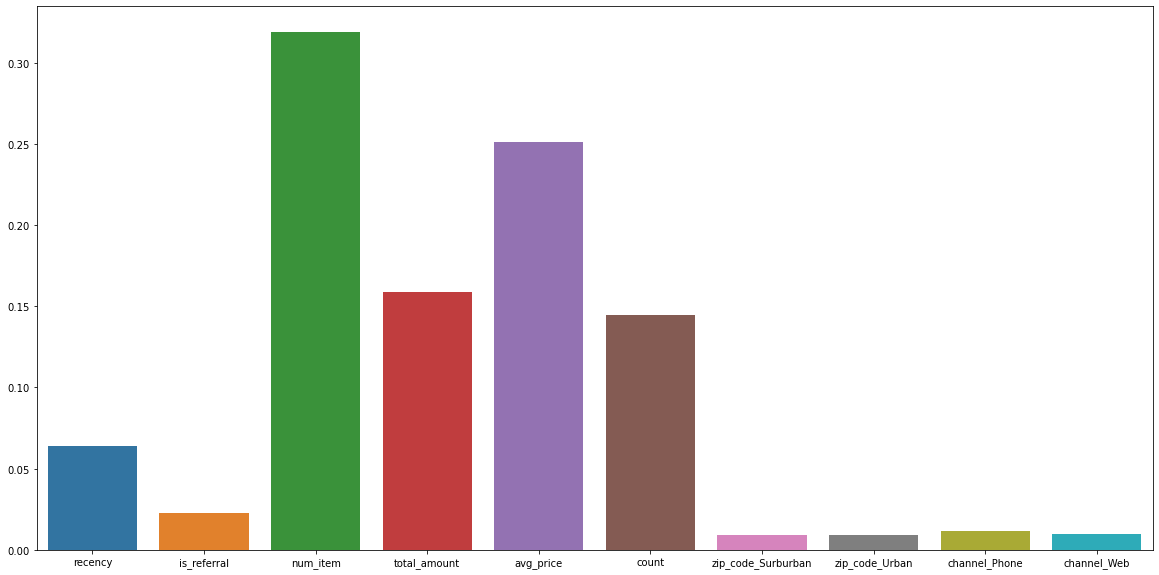

In [74]:
plt.figure(figsize=(20, 10))
sns.barplot(x=X_train.columns, y=rf.feature_importances_)

- Random Forest에서는 너무 많은 tree를 사용하기 때문에, tree plot을 만들어 확인하기는 어려움